In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words =  open('names.txt').read().splitlines()
words[-8:]

['yama',
 'yami',
 'yamuna',
 'yash',
 'yashoda',
 'yuda',
 'yudhishthira',
 'yudhisthira']

In [3]:
len(words)

32616

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [66]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    
    # print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join([itos[i] for i in context]), '--->', itos[ix])
        context = context[1:] + [ix] #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [67]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([232331, 3]), torch.int64, torch.Size([232331]), torch.int64)

In [68]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [20,  8,  9],
        [ 8,  9, 18],
        [ 9, 18,  1]])

In [45]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [46]:
C = torch.randn((27, 2))

In [47]:
C[5]

tensor([ 0.2460, -1.1472])

In [48]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [49]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [50]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[-0.6388,  0.9577, -0.9406,  ..., -0.6572,  0.5932, -0.7054],
        [-0.9465,  0.9380, -0.9134,  ..., -0.3349, -0.8263, -0.8746],
        [-0.9551,  0.8126, -0.5483,  ...,  0.9531, -0.9982, -0.4813],
        ...,
        [ 0.9769,  0.9549, -0.8593,  ..., -0.9978,  0.9999, -0.5934],
        [-0.9874,  0.9961, -0.6795,  ...,  0.7294, -0.8788, -0.9996],
        [-0.5771,  0.9711, -0.9976,  ...,  0.3858, -0.9880,  0.9983]])

In [51]:
h.shape

torch.Size([32, 100])

In [52]:
(emb.view(-1, 6) @ W1).shape

torch.Size([32, 100])

In [53]:
b1.shape

torch.Size([100])

In [54]:
# 32, 100
#  1, 100

In [55]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [56]:
logits = h @ W2 + b2

In [57]:
logits.shape

torch.Size([32, 27])

In [58]:
counts = logits.exp()

In [59]:
prob = counts / counts.sum(-1, keepdim=True)

In [60]:
prob.shape

torch.Size([32, 27])

In [61]:
prob[0].sum()

tensor(1.0000)

In [62]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(15.1751)

In [187]:
## ----------------Let's make it in a sense :) -------------------

In [188]:
Xtr.shape, Ytr.shape  # dataset

(torch.Size([186039, 3]), torch.Size([186039]))

In [213]:
g = torch.Generator().manual_seed(2147483647)  # reproducibility
C = torch.randn((27, 10), generator=g)  # embedding
W1 = torch.randn((30, 200), generator=g)  # weights
b1 = torch.randn(200, generator=g)  # bias
W2 = torch.randn((200, 27), generator=g)  # weights
b2 = torch.randn(27, generator=g)  # bias
parameters = [C, W1, b1, W2, b2]

In [214]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [176]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdim=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)  # same as the above but more stable and efficient (above is for raw understanding)
loss

tensor(19.4980)

In [177]:
logits =torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

In [178]:
counts

tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])

In [179]:
# That's why we should use the cross-entropy loss function

In [180]:
## ------------------- Training -------------------

In [215]:
for p in parameters:
    p.requires_grad = True

In [216]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre
lrs                                  # learning rate

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [217]:
lri = []
lossi = []
stepi = []

In [230]:


for i in range(30000):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass
    emb = C[Xtr[ix]]                                 # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2                       # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])        
    # print(i, loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.223118305206299


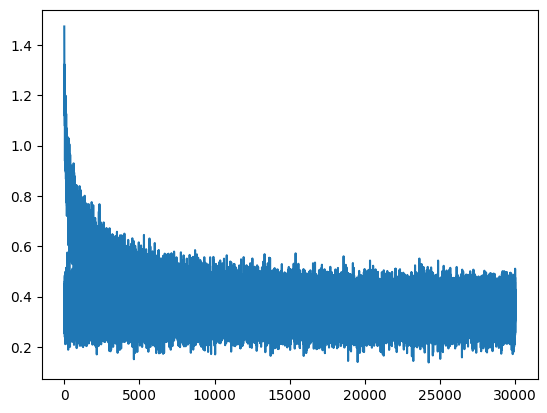

In [231]:
plt.plot(stepi, lossi)

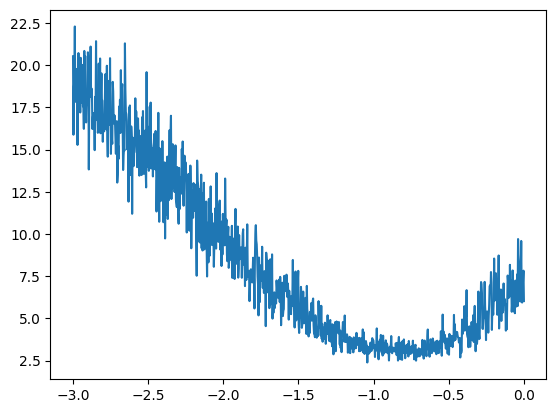

In [153]:
plt.plot(lri, lossi)

In [232]:
emb = C[Xtr]                                # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2                       # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1313, grad_fn=<NllLossBackward0>)

In [233]:
emb = C[Xdev]                                # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2                       # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4175, grad_fn=<NllLossBackward0>)

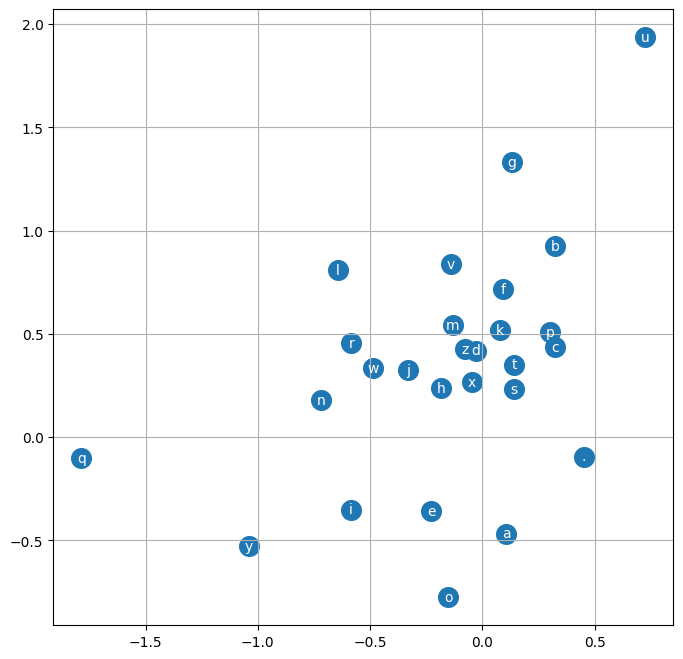

In [212]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [ ]:
# training split, validation/dev split, test split
# 80% train, 10% validation, 10% test

In [166]:
# build the dataset

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([186039, 3]) torch.Size([186039])
torch.Size([23095, 3]) torch.Size([23095])
torch.Size([23197, 3]) torch.Size([23197])


In [167]:
len(words)

32616

In [168]:
n1

26092

In [ ]:
n2 - n1        # validation set

3262

In [172]:
len(words) - n2            # test set

3262

In [234]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)  # reproducibility

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=-1)
        ix = torch.multinomial(prob, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([itos[i] for i in out]))

mora.
mayannieel.
ndyn.
aley.
thruthadrae.
caileydoeliah.
miloea.
edelleananarandy.
korlya.
miyshubergahiriestin.
jowelle.
jose.
caylen.
geder.
yarue.
els.
kaysh.
sanyah.
hil.
salynn.
